# Blackbox Inverse Search
A common problem is to have a given continuous "blackbox" (unknown) function, 

$y=f(x)$

and want to find the $x$ that most closely matches a given $y_{target}$. The modern approach is to use [auto-diff](https://en.wikipedia.org/wiki/Automatic_differentiation) to compute its gradient and optimize a loss function 

$L(x) = D(f(x), y_{target})$

(where $D$ is a distance function) using e.g. [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS). However, auto-diffing is not always possible -- the function may be closed-source, written in some language where auto-diff is non-trivial, or even be non-software (e.g. analog circuits, robotics, actuators, sensors etc). For these cases, one has traditionally resorted to Direct Search methods, that only look at the loss value $L(x)$. This is a severely information-starved approach that can only learn a few bits of information about the problem per iteration. It is inherently suboptimal to ignore $y$, especially if it is high dimension. A better approach is to try to match $y$ to its target directly. Let me introduce the...

## LinApprox algorithm
in which we approximate our function as a hyperplane passing through $y_{opt} = f(x_{opt})$, with $x_{opt} = \mathrm{argmin} L(x_i)$, i.e. our best example yet, as

$f(x) \approx \hat{f}(x) = y_{opt} + A \dot (x-x_{opt}).$

$A$ (the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) at $x_{opt}$) is estimated using [regularized least squares](https://en.wikipedia.org/wiki/Tikhonov_regularization) on the latest $M=dim(X)+1$ examples. This approximation is used to determine the next $x$ as

$x_{next} = \mathrm{argmin} D(\hat{f}(x), y_{target}).$

If $D$ is the L2 norm, $x_{next}$ is directly computable by least squares. For most other common distance measures, there are efficient methods for this purpose. As seen in Figure 1 below, this simple algorithm vastly outperforms existing Direct Search algorithms from the venerable scipy.optimize library.

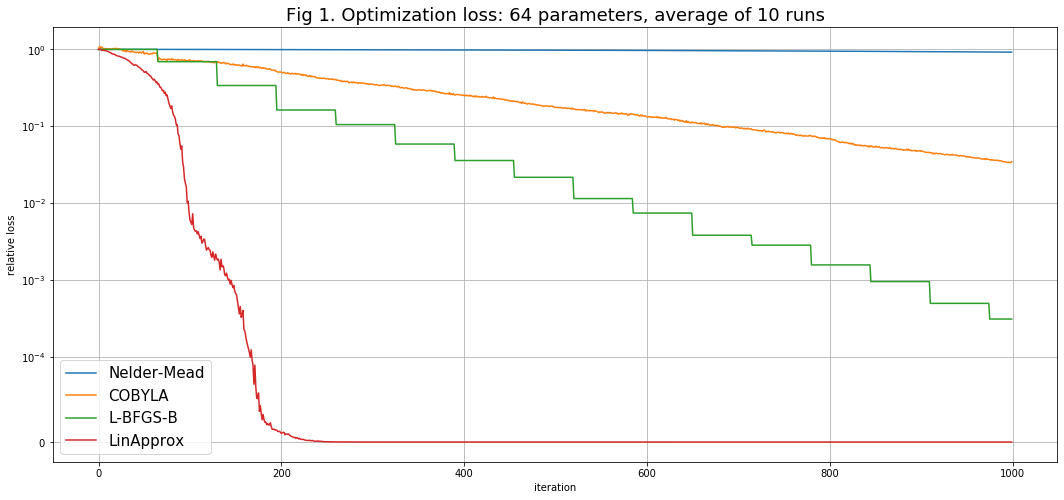

,Method,Avg Loss,iters/sec
0,Nelder-Mead,0.917,13.1k
1,COBYLA,0.0327,4.2k
2,L-BFGS-B,0.000312,33.4k
3,LinApprox,1.63e-12,2.3k


In [142]:
import numpy as np

dimX = 64; dimY = 256
maxNumIters = 1000

# define problem
A=[]; a0=[]; xTarget=[]; xStart=[]; yTarget=[]
def setupRandomProblem():
    global A, a0, xTarget, xStart, yTarget
    A  = np.random.rand(dimY,dimX)-.5
    a0 = np.random.rand(dimY)-.5
    xTarget = np.random.rand(dimX)-.5
    xStart  = np.random.rand(dimX)-.5
    yTarget = blackboxFunction(xTarget)

# this is the unknown function that we want to invert
def blackboxFunction(x):
    tmp = np.dot(A,np.sin(x) + np.exp(x)) + a0
    return np.sign(tmp) * (np.sqrt(1+np.abs(tmp))-1)

def lossFun(y):
    L = np.sum((y-yTarget)**2)
    global lossList, lossCount # needed to count iterations used by scipy.optimize
    if lossCount<maxNumIters:
        lossList[lossCount] = L**.5
    lossCount += 1
    return L;

def LinApprox_search(xStart, yTarget, nIter):
    nX = len(xStart); nMem = nX+1
    memX = np.zeros((nMem, nX))
    memY = np.zeros((nMem, len(yTarget)))
    memLoss = np.zeros(nMem)
    x = 1.0*xStart # make hard copy
    
    def regularizedLS(A, b, regMult, regAdd):
        I = np.eye(A.shape[1])
        return np.linalg.solve(np.dot(A.T,A)*(1+regMult*I)+regAdd*I, np.dot(A.T,b))
    
    for iter in range(nIter):
        m = iter % nMem
        if iter<3:
            x += .1 * (np.random.rand(nX)-.5)
        else:
            M = np.minimum(iter,nMem) # current memory size
            minI = np.argmin(memLoss[:M]) # get current best
            dI = (np.arange(nMem) != minI) * (np.arange(nMem)<iter)
            dX = memX[dI,:] - memX[minI,:]
            dY = memY[dI,:] - memY[minI,:]
            yStep = yTarget - memY[minI,:]
        
            # estimate A such that A*dx ~= dy (with small tikhonov term)
            lsA = regularizedLS(dX, dY, .001, 1e-20).T
        
            # find x minimizing norm(A*x - yStep)
            xStep = regularizedLS(lsA, yStep, .01, 1e-20)
            
            # make sure step is **reasonable**
            stepNorm = np.sum(xStep**2)
            x = memX[minI,:] + xStep * np.minimum(1.0, 1.0 / stepNorm)
        
        memX[m,:] = x
        memY[m,:] = blackboxFunction(x)
        memLoss[m] = lossFun(memY[m,:])

    return x

##### gradient-free scipy.optimize methods for comparison ############
import time
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
%matplotlib inline

methods = ['Nelder-Mead', 'COBYLA', 'L-BFGS-B', 'LinApprox']
methStats = np.zeros([len(methods),3])

numReps = 10
avgLossMat = np.zeros((maxNumIters,len(methods)))

for rep in range(numReps):
    setupRandomProblem()
    for mInd, methodName in enumerate(methods):
        lossList = np.zeros(maxNumIters)
        lossCount = 0
        T0 = time.perf_counter()
        if methodName=='LinApprox':
            res = LinApprox_search(xStart, yTarget, maxNumIters)
        else:
            # standalone loss function needed for scipy.optimize methods
            def blackboxLoss(x):
                y = blackboxFunction(x)
                return lossFun(y)
            opts = {'maxiter':maxNumIters, 'disp':False}
            res = scipy.optimize.minimize(blackboxLoss, xStart, method=methodName, options=opts)
        
        assert(lossCount>=maxNumIters)
        avgLossMat[:,mInd] += lossList
        methStats[mInd,0] += lossCount
        methStats[mInd,1] += (time.perf_counter()-T0)
        methStats[mInd,2] += np.min(lossList)/lossList[0]

plt.figure(figsize=(18, 8));
_=plt.plot(avgLossMat/avgLossMat[0,0])
plt.rcParams.update({'font.size': 15})
plt.yscale('symlog', linthreshy=1e-4)
plt.title("Fig 1. Optimization loss: %d parameters, average of %d runs" % (dimX, numReps))
plt.xlabel('iteration')
plt.ylabel('relative loss')
plt.grid(True)
plt.legend(methods)
plt.show()

tabData = []
for ind, meth in enumerate(methods):
    tabData.append([meth, "%.3g" % (methStats[ind,2]/numReps), "%.1fk" % (1e-3*methStats[ind,0]/methStats[ind,1]) ])

import pandas as pd
pd.DataFrame(tabData, columns=["Method", "Avg Loss", "iters/sec"])
